In [ ]:
! pip install pmdarima

     |████████████████████████████████| 1.5MB 2.9MB/s 
     |████████████████████████████████| 9.5MB 10.2MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import datetime
import math
import itertools

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from pmdarima.arima import ARIMA
import pmdarima as pm

pd.set_option('display.float_format', lambda x: '{:.15f}'.format(x))

In [ ]:
df = pd.read_csv('result_ppg_canada_sales.csv')

df.columns = [c.lower() for c in df.columns]

fact_col_list = ['total_curr_yr_sales_dollar', 'total_curr_yr_sales_units',	'total_curr_yr_sales_lbs']
for c in fact_col_list:
    df[c] = df[c].astype(float)

df['fscl_wk_end_dt'] = pd.to_datetime(df['fscl_wk_end_dt'])
df['fscl_mth_end_dt'] = pd.to_datetime(df['fscl_mth_end_dt'])

df = df.sort_values(by=['fscl_wk_end_dt','epm'])
df.set_index('fscl_wk_end_dt', inplace=True)
unique_epm_list = list(set(list(df.epm)))

df_orig = df.copy()
df = df[['epm','total_curr_yr_sales_lbs']]

#Separate dates for future plotting
train_dates = list(df[df.index <= '2020-12-26'].index)
test_dates = list(df[df.index > '2020-12-26'].index)

df

,epm,total_curr_yr_sales_lbs
fscl_wk_end_dt,,
2017-01-14,NA01NCA1SCE,2562.559999999999945
2017-01-14,NA01NCBAKINGMM,63807.756959100006497
2017-01-14,NA01NCBBQSAUCE,128298.620999999999185
2017-01-14,NA01NCBEANS,839414.529800000018440
2017-01-14,NA01NCBRAVO,240612.152000000001863
...,...,...
2021-06-26,NA01NFSCSHELFS,3246.320000000000618
2021-06-26,NA01NFSCTBLPRD,166.669272000000007
2021-06-26,NA01NFSCTOMJU,5433.260800000000017


In [ ]:
epm_df = df[df.epm == 'NA01NCPNBTRSPR'][['total_curr_yr_sales_lbs']]
# Using multiple features (predictors)
total_curr_yr_sales_lbs_values = epm_df.values#.flatten()
print("Shape of training data " + str(total_curr_yr_sales_lbs_values.shape))

train_value = epm_df.index.get_loc('2020-12-26')
train, test = total_curr_yr_sales_lbs_values[0:train_value,:], total_curr_yr_sales_lbs_values[train_value + 1:,:]
print(len(train), len(test))

Shape of training data (233, 1)
206 26


In [ ]:
# fitting a stepwise model:
stepwise_fit = pm.auto_arima(epm_df, start_p=1, start_q=1, max_p=52, max_q=52, m=12,
                             start_P=0, seasonal=True, d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=6374.558, Time=0.51 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=6533.655, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=6444.619, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=6374.554, Time=0.30 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=6450.765, Time=0.10 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=6375.737, Time=0.57 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=6375.643, Time=0.99 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=6411.346, Time=0.30 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=6376.546, Time=1.35 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=6426.660, Time=0.17 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=6371.322, Time=0.43 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=6452.198, Time=0.13 sec
 ARIMA(0,1,2)(1,1,1)[12]             : AIC=6372.646, Time=0.71 sec
 ARIMA(0,1,2)(0,1,2)[12]             : AIC=6372.594, Time=1.06 sec
 ARIMA(0,1,2)(1,1,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  233
Model:             SARIMAX(1, 1, 3)x(0, 1, [1], 12)   Log Likelihood               -3177.331
Date:                              Tue, 13 Jul 2021   AIC                           6366.662
Time:                                      22:45:42   BIC                           6387.023
Sample:                                           0   HQIC                          6374.884
                                              - 233                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9275      0.134     -6.926      0.000      -1.190      -0.665
ma.L1          0.3563      0.139      2.571      0.010       0.085       0.628
ma.L2         -0.6154      0.125     -4.927      0.000      -0.860      -0.371
ma.L3         -0.1772      0.098     -1.816      0.069      -0.368       0.014
ma.S.L12      -0.8747      0.087    -10.035      0.000      -1.046      -0.704
sigma2      2.676e+11   1.69e-13   1.58e+24      0.000    2.68e+11    2.68e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):                18.09
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               0.47   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.6e+40. Standard errors may be unstable.
"""

In [ ]:
next_2year = stepwise_fit.predict(n_periods=104)
next_2year

array([1749231.45561385, 1662039.95707229, 1752932.06531406,
       1798316.93724264, 1827137.00804022, 1941612.56223459,
       1854933.56418985, 1811975.82762673, 1798585.73454051,
       1702425.97849438, 1762032.10912439, 1677394.03078865,
       1817789.49485754, 1719573.40569628, 1755180.06706795,
       1851840.19235828, 1833104.31930161, 1991686.29223785,
       1864100.18529006, 1859082.31341193, 1810504.36738487,
       1746980.07287416, 1776317.99272642, 1719752.58566858,
       1834111.66197529, 1760043.38122855, 1773253.82325708,
       1890685.6323481 , 1852684.7734782 , 2029134.32431255,
       1884976.68479057, 1895328.31030171, 1832495.71106494,
       1782192.09208985, 1799268.31332013, 1754075.18846461,
       1857886.88414517, 1793600.91763348, 1797738.61684699,
       1923585.0669125 , 1877779.93273433, 2061467.66678671,
       1910596.87399574, 1927174.70647835, 1858567.52535758,
       1813619.62232445, 1825728.6106317 , 1785142.4147431 ,
       1884681.35035077,

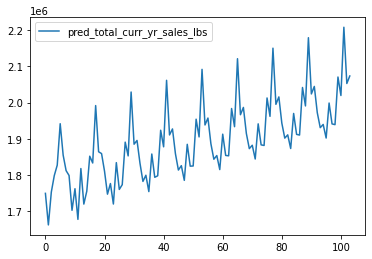

In [ ]:
df_pred = pd.DataFrame(data=next_2year, columns=['pred_total_curr_yr_sales_lbs'])
df_pred.head()
df_pred.plot()

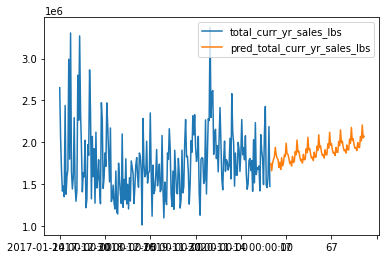

In [ ]:
df_total = epm_df.append(df_pred)
df_total.plot()